In [1]:
using Revise
includet("../cluster_env/runs/rg_unstructured/job.jl")

In [31]:
using GLMakie

# Setup

In [32]:
bp = "../data/failed_run/debug_sp/"
get_run(i) = load_object(bp*string(i)*".jld2")

get_run (generic function with 1 method)

# Testing

In [60]:
ssp = get_run(85);

In [61]:
@time sss = solve(p, DynamicSS(QNDF());
# @time s = solve(p, DynamicSS(TRBDF2());
    callback=make_timer_callback(10),
    abstol=1000*eps(),
    reltol=1000*eps(),
    # maxiters=1000
)
sss.retcode
maximum(abs, sss.resid)

  0.011698 seconds (6.96 k allocations: 1.288 MiB)


4.287971378415592e-12

In [67]:
xp = ODEProblem(p.f, p.u0, (0., 10000000000000.), p.p);
xs = solve(xp, QNDF())
f = plot_mmicrm_sol(xs)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

### Finding which run is the problematic one!

In [ ]:
@time for i in 1:100
    p = get_run(i);
    @printf "Starting %d" i
    flush(stdout)
    @time s = solve(p, DynamicSS(QNDF());
        callback=make_timer_callback(10),
        abstol=100*eps(),
        reltol=100*eps(),
    )
    @show s.retcode
    @show maximum(abs, s.resid)
end

Starting 1  0.014292 seconds (9.16 k allocations: 1.768 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 5.165222044314577e-13
Starting 2  0.021374 seconds (13.84 k allocations: 2.590 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 9.740243278990568e-13
Starting 3  0.015802 seconds (10.83 k allocations: 2.061 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 4.973654013528737e-13
Starting 4  0.018191 seconds (12.05 k allocations: 2.275 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 8.325339814070066e-13
Starting 5  0.016430 seconds (9.76 k allocations: 1.874 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 3.552713678800505e-13
Starting 6  0.015433 seconds (9.95 k allocations: 1.907 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximum(abs, s.resid) = 5.757003187448364e-13
Starting 7  0.018997 seconds (12.68 k allocations: 2.385 MiB)
s.retcode = SciMLBase.ReturnCode.Success
maximu

# Running a single system

In [56]:
ps = rsg();

In [17]:
ps = params[3];

## No space solver

In [ ]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=nothing,
);
maximum(abs, sss.resid)

  0.438351 seconds (490 allocations: 614.641 KiB)


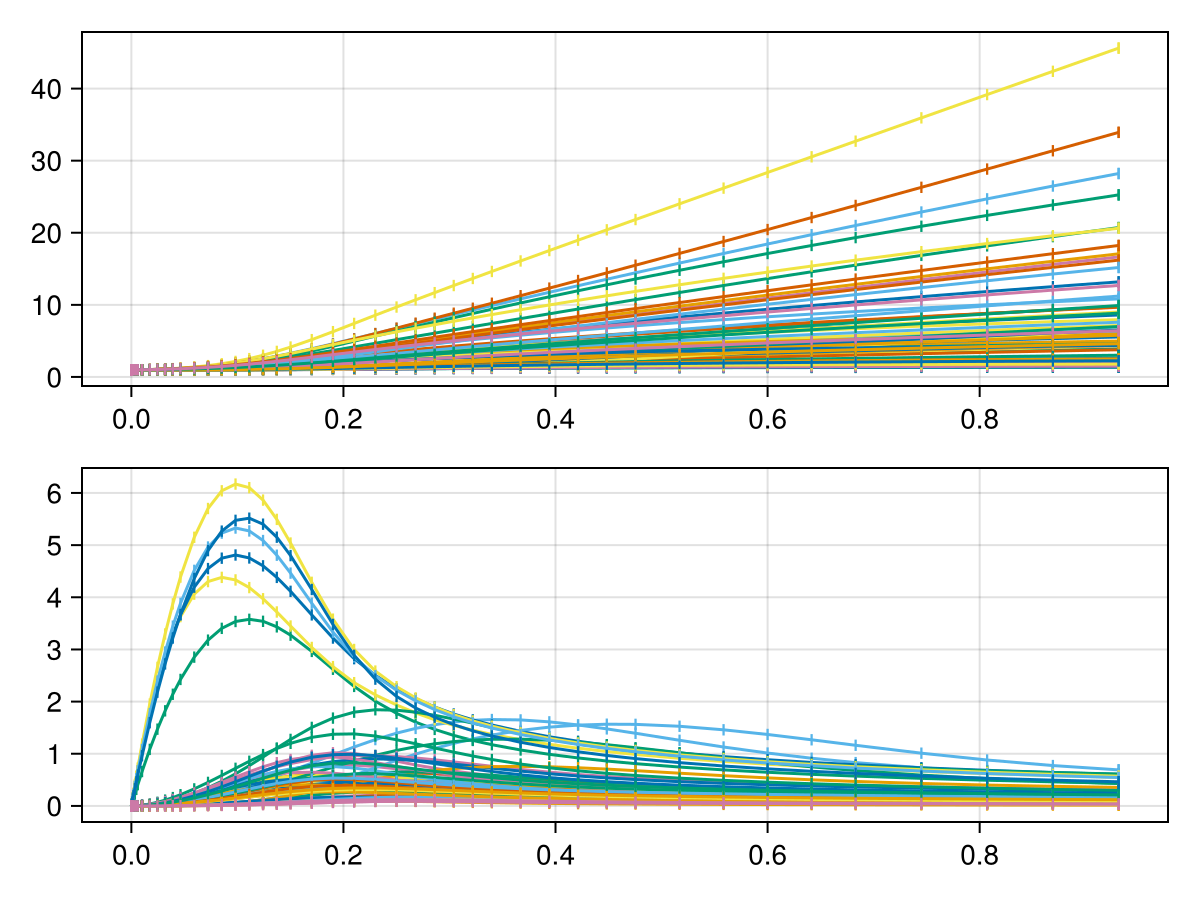

In [236]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 10000);
# p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=make_timer_callback(0.5)
)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [201]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 4.3456097054139775e-9


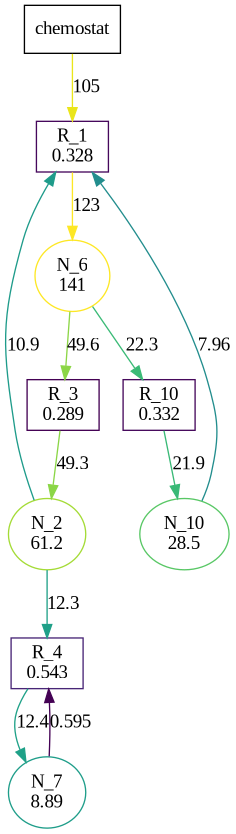

In [30]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10
)

### Linear stability

In [418]:
ks = LinRange(0., 1000., 10000)

Ds = get_Ds(ps)
Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1e-8, get_Ns(ps)[2])
)
Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-5.464753751148015e-5

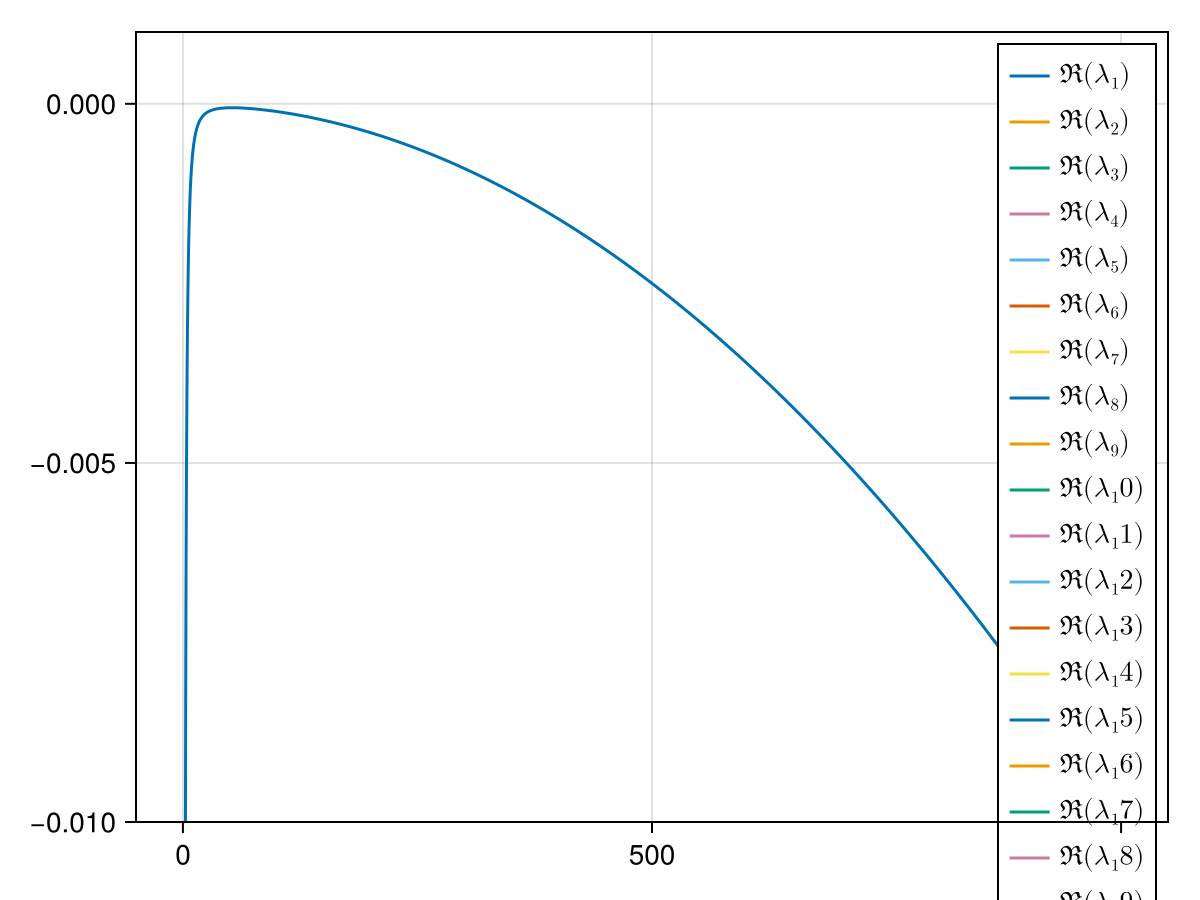

In [419]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


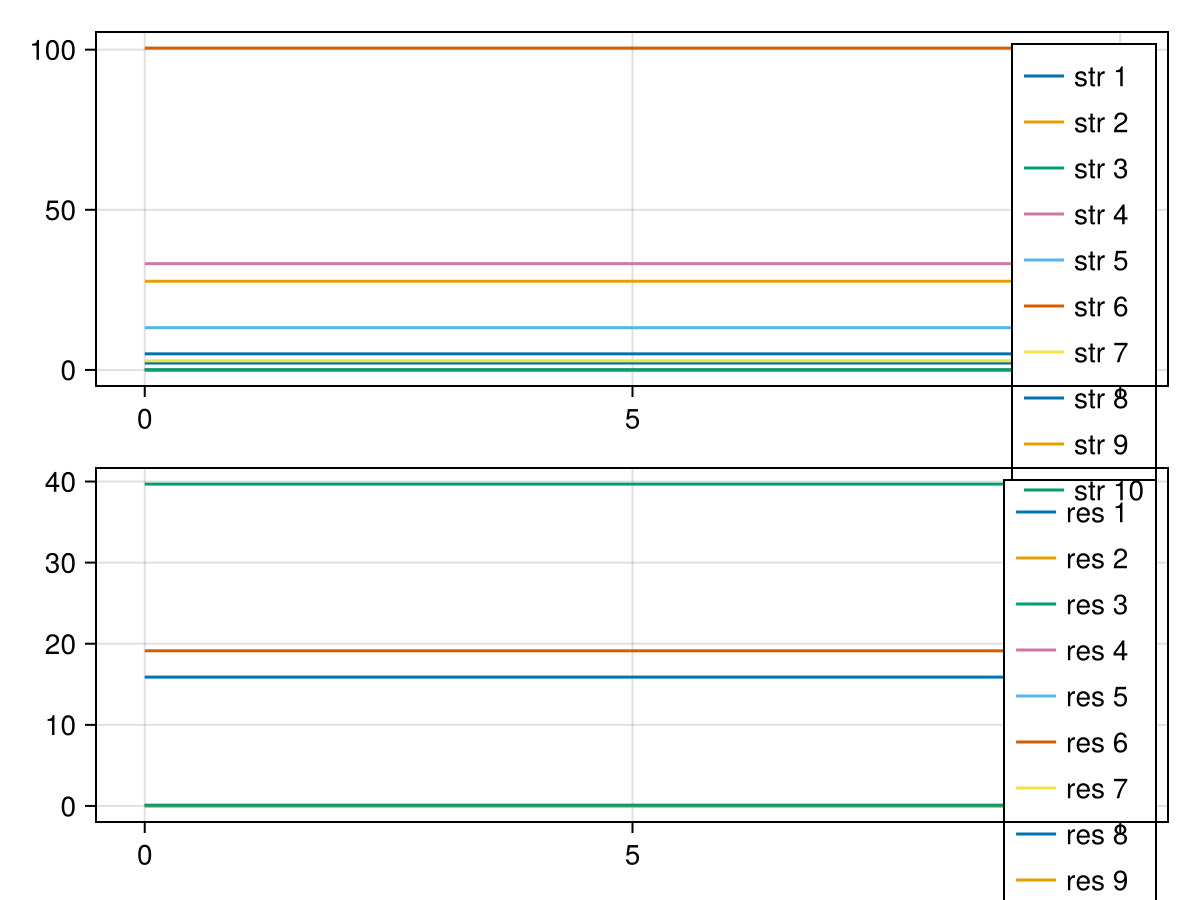

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

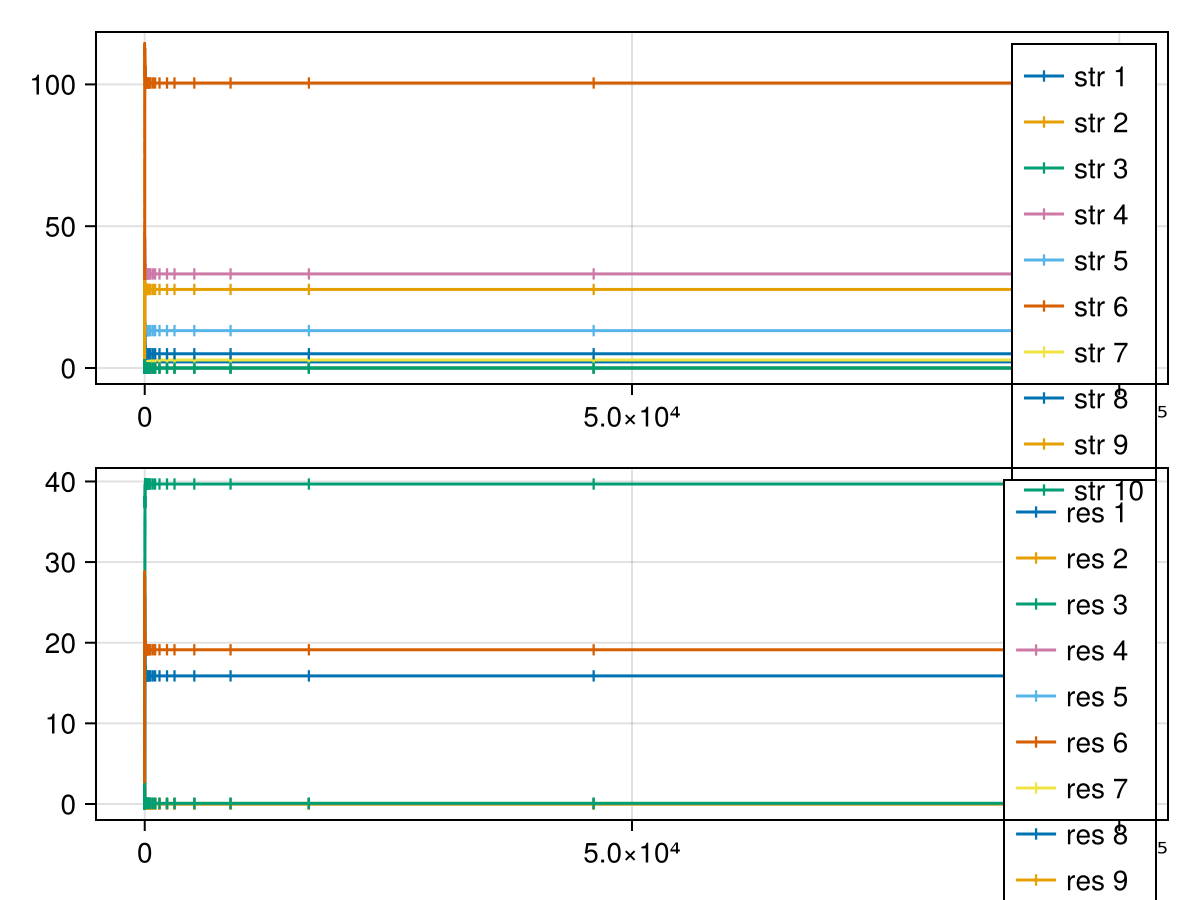

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()